In [43]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from pathlib import Path
import glob

# ---  Configuration ---
base_dir = Path("../data/predictions")
output_dir = Path("../figures/predictions")
rcp_scenarios = ["RCP26", "RCP45", "RCP85"]
PREDICTION_START_INVNR = 550

# Run diagnostic to check the number of unique plots per vegetation belt
RUN_DIAGNOSTIC = False

# Plotting-Specific Configuration
plt.style.use('seaborn-v0_8-whitegrid')

# Palettes and Mappings
COLOR_PALETTE = {"RCP26": "#377eb8", "RCP45": "#ff7f00", "RCP85": "#e41a1c"}
MANAGEMENT_MAP = {1.0: 'Managed', 3.0: 'Unmanaged'}
LINESTYLE_MAP = {'Managed': 'solid', 'Unmanaged': 'dashed'}
VEG_BELT_MAP = {
    1: {'long': 'Upper Subalpine', 'short': 'US'},
    2: {'long': 'Subalpine', 'short': 'SA'},
    3: {'long': 'High-Montane', 'short': 'HM'},
    4: {'long': 'Upper Montane (N)', 'short': 'UM'},
    5: {'long': 'Lower Montane (N)', 'short': 'LM'},
    6: {'long': 'Lower/Upper Montane (S)', 'short': 'MO'},
    7: {'long': 'Submontane (N)', 'short': 'SM'},
    8: {'long': 'Colline with Beech (S)', 'short': 'CO'},
    9: {'long': 'Colline', 'short': 'CO'},
    10: {'long': 'Hyperinsubric (S)', 'short': 'HY'}
}
VEG_BELT_ORDER = ['CO', 'SM', 'LM', 'MO', 'UM', 'HM', 'SA', 'US', 'HY']

# Font Sizes
TITLE_FONTSIZE = 18
AXIS_LABEL_FONTSIZE = 14
TICK_LABEL_FONTSIZE = 12
LEGEND_FONTSIZE = 11

print("Configuration loaded successfully.")
print(f"Data will be read from and plots saved to: {base_dir} and {output_dir} respectively.")

Configuration loaded successfully.
Data will be read from and plots saved to: ../data/predictions and ../figures/predictions respectively.


In [44]:
# --- Load and Combine All Simulation Data ---

all_scenarios_data = []
print("\nStarting to load and combine prediction data...")
for rcp in rcp_scenarios:
    scenario_dir = base_dir / f"Predictions_{rcp}"
    prediction_files = glob.glob(str(scenario_dir / f"NFI_{rcp}_prediction_seed_*.csv"))
    
    scenario_dfs = [pd.read_csv(file) for file in prediction_files]
    for i, df in enumerate(scenario_dfs):
        df['seed'] = int(Path(prediction_files[i]).stem.split('_seed_')[-1])
        
    combined_df = pd.concat(scenario_dfs, ignore_index=True)
    combined_df['rcp'] = rcp
    all_scenarios_data.append(combined_df)


master_df = pd.concat(all_scenarios_data, ignore_index=True)
print("\nMaster DataFrame created successfully.")
print(f"Shape: {master_df.shape}")



Starting to load and combine prediction data...

Master DataFrame created successfully.
Shape: (15516900, 36)


In [45]:
# --- Prepare Data for Management Type Plots ---

# Create a mapping from inventory number (INVNR) to the median year for use as the x-axis.
year_map = (
    master_df.groupby('INVNR', as_index=False)['INVYR']
    .median()
    .rename(columns={'INVYR': 'median_year_per_INVNR'})
)
year_map['median_year_per_INVNR'] = year_map['median_year_per_INVNR'].round().astype(int)

# Filter for managed and unmanaged plots
df_mgmt = master_df[master_df['BEWIRTINT1'].isin(MANAGEMENT_MAP.keys())].copy()
df_mgmt['management_type'] = df_mgmt['BEWIRTINT1'].map(MANAGEMENT_MAP)

# Aggregate by INVNR, SEED, and MANAGEMENT_TYPE
mean_per_invnr_df_mgmt = df_mgmt.groupby(['rcp', 'INVNR', 'seed', 'management_type']).agg(
    mean_BASFPH=('BASFPH', 'mean'),
    mean_HWSW_prop=('HWSW_prop', 'mean')
).reset_index()

# Calculate final statistics across all seeds
plot_stats_df_mgmt = mean_per_invnr_df_mgmt.groupby(['rcp', 'INVNR', 'management_type']).agg(
    final_mean_BASFPH=('mean_BASFPH', 'mean'),
    min_BASFPH=('mean_BASFPH', 'min'),
    max_BASFPH=('mean_BASFPH', 'max'),          
    final_mean_HWSW_prop=('mean_HWSW_prop', 'mean'),
    min_HWSW_prop=('mean_HWSW_prop', 'min'),
    max_HWSW_prop=('mean_HWSW_prop', 'max')       
).reset_index()

# Merge the aggregated statistics
plot_data_management = (
    plot_stats_df_mgmt.merge(year_map, on='INVNR', how='left')
    .rename(columns={'median_year_per_INVNR':'mean_year'})  
)


# Get the prediction start year for the vertical line
prediction_start_year = plot_data_management[plot_data_management['INVNR'] == PREDICTION_START_INVNR]['mean_year'].iloc[0]

print("Data prepared for management-specific plots.")


Data prepared for management-specific plots.


Saved PNG to: ../figures/predictions/basal_area_by_management.png
Saved PDF to: ../figures/predictions/basal_area_by_management.pdf


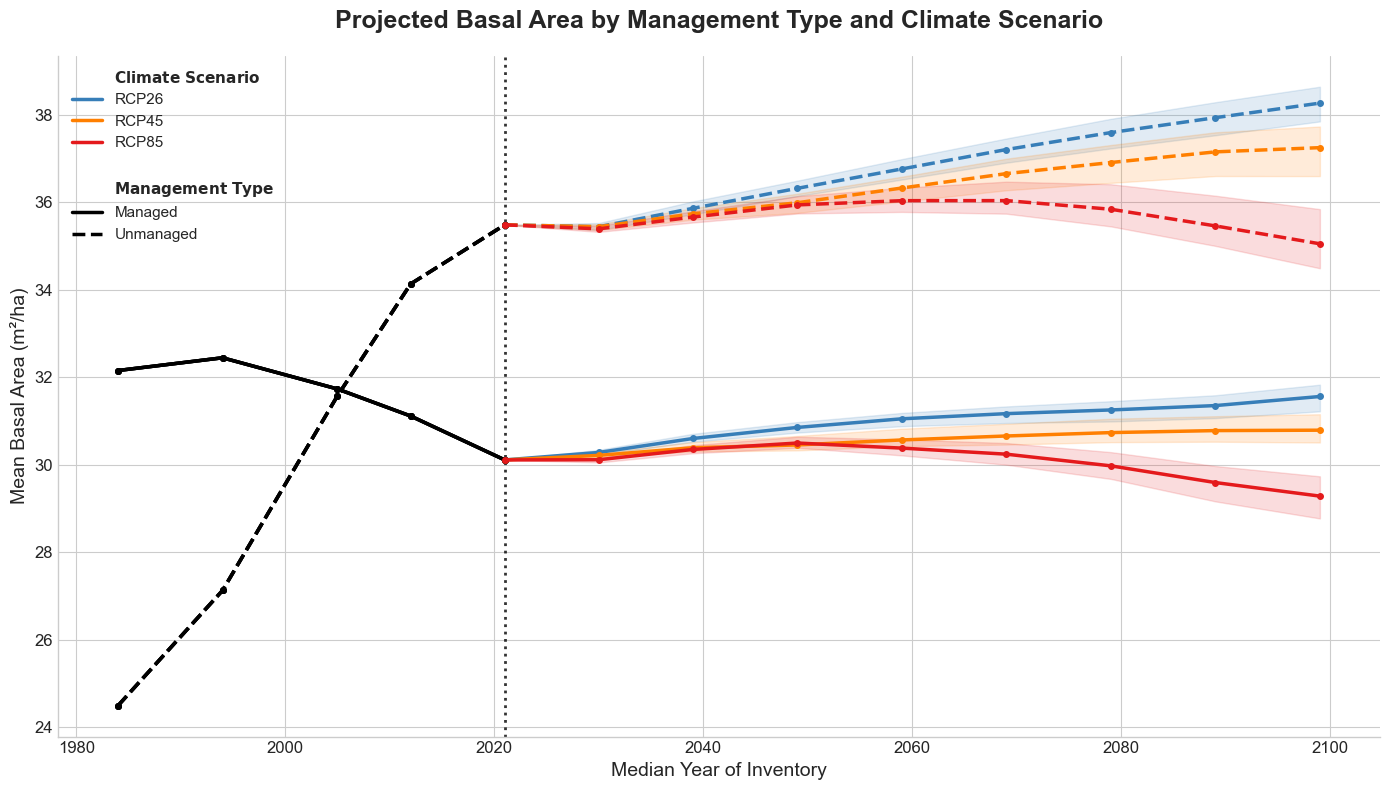

Saved PNG to: ../figures/predictions/hw_proportion_by_management.png
Saved PDF to: ../figures/predictions/hw_proportion_by_management.pdf


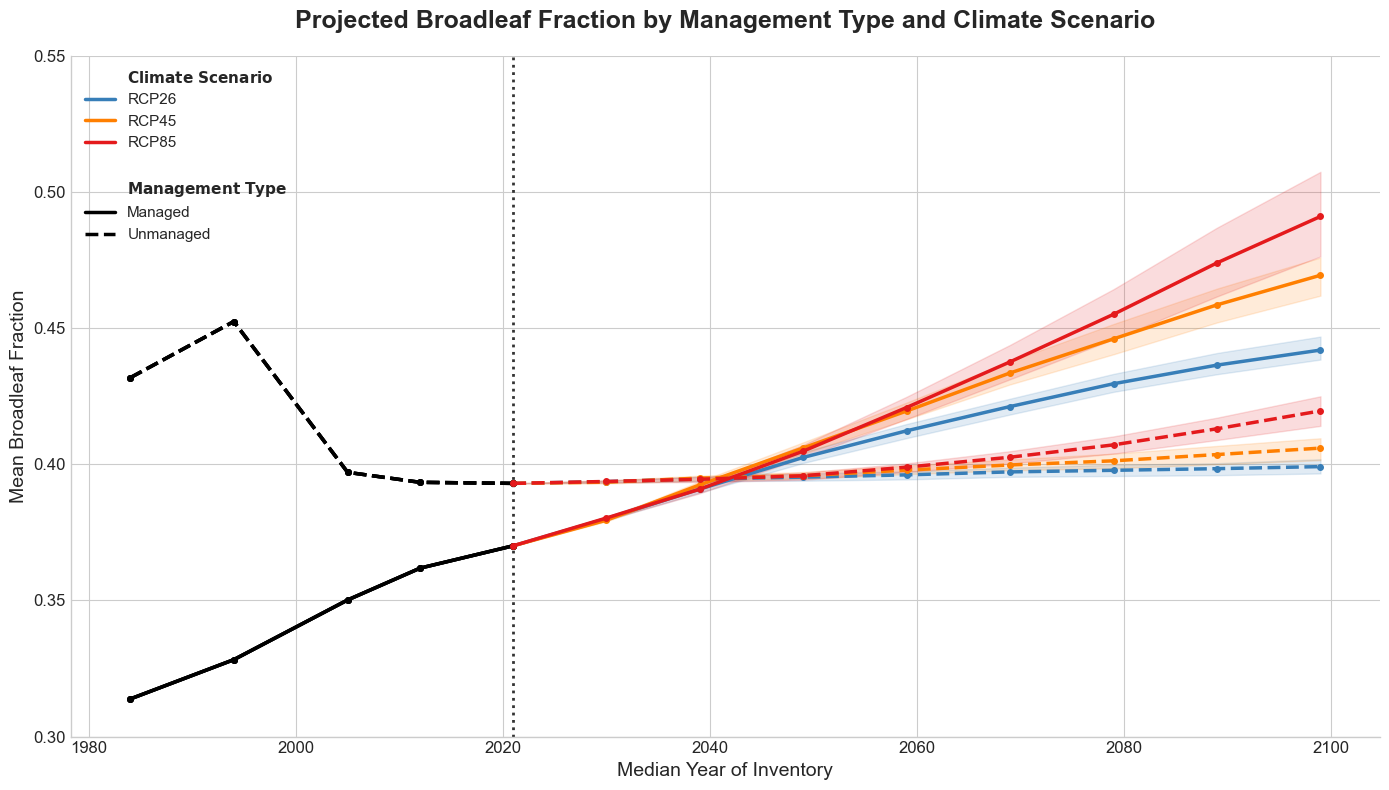

In [46]:
# --- Reusable Plotting Function (by Management)---

def create_plot_by_management(
    data, x_col, y_mean_col, y_min_col, y_max_col, 
    y_label, title, output_filename, 
    color_palette, linestyle_map, prediction_start_year, ylim=None
):
    """Generates a plot with a single, clear, custom legend."""

    fig, ax = plt.subplots(figsize=(14, 8))

    # Plot each series
    for rcp in data['rcp'].unique():
        for mgmt_type, linestyle in linestyle_map.items():
            subset_data = data[(data['rcp'] == rcp) & (data['management_type'] == mgmt_type)]
            color = color_palette.get(rcp)
           # Split data into before/after prediction start
            hist_data = subset_data[subset_data[x_col] <= prediction_start_year]
            fut_data  = subset_data[subset_data[x_col] >= prediction_start_year]

            # Plot historical part in black
            if not hist_data.empty:
                ax.plot(
                    hist_data[x_col], hist_data[y_mean_col],
                    color='black', linewidth=2.5, linestyle=linestyle,
                    marker='o', markersize=4, zorder=10
                )

            # Plot future part in scenario color
            if not fut_data.empty:
                ax.plot(
                    fut_data[x_col], fut_data[y_mean_col],
                    color=color, linewidth=2.5, linestyle=linestyle,
                    marker='o', markersize=4, zorder=10
                )
                ax.fill_between(
                    fut_data[x_col], fut_data[y_min_col], fut_data[y_max_col],
                    color=color, alpha=0.15, zorder=5
                )

    # Create custom legend 
    legend_handles = []
    legend_labels = []
    legend_handles.append(Line2D([0], [0], color='none'))
    legend_labels.append(r"$\bf{Climate\ Scenario}$")
    for name, color in color_palette.items():
        legend_handles.append(Line2D([0], [0], color=color, lw=2.5))
        legend_labels.append(name)
    legend_handles.append(Line2D([0], [0], color='none'))
    legend_labels.append("")
    legend_handles.append(Line2D([0], [0], color='none'))
    legend_labels.append(r"$\bf{Management\ Type}$")
    for name, ls in linestyle_map.items():
        legend_handles.append(Line2D([0], [0], color='black', lw=2.5, linestyle=ls))
        legend_labels.append(name)
    
    ax.legend(legend_handles, legend_labels, loc='upper left',
              fontsize=LEGEND_FONTSIZE, handlelength=2)

    # Add prediction start line
    ax.axvline(x=prediction_start_year, color='black', linestyle=':', lw=2, alpha=0.8)
    
    # Customize aesthetics
    ax.set_title(title, fontsize=TITLE_FONTSIZE, pad=20, weight='bold')
    ax.set_xlabel("Median Year of Inventory", fontsize=AXIS_LABEL_FONTSIZE)
    ax.set_ylabel(y_label, fontsize=AXIS_LABEL_FONTSIZE)
    if ylim: ax.set_ylim(ylim)
    ax.tick_params(axis='both', which='major', labelsize=TICK_LABEL_FONTSIZE) # 
    sns.despine(ax=ax) # Remove top and right spines
    plt.tight_layout()

    # Save figure
    png_path = output_filename.with_suffix('.png')
    plt.savefig( 
        png_path, dpi=300, bbox_inches='tight')
    print(f"Saved PNG to: {png_path}")
    pdf_path = output_filename.with_suffix('.pdf')
    plt.savefig(pdf_path, bbox_inches='tight')
    print(f"Saved PDF to: {pdf_path}")
    plt.show()

# --- Generate and Save the Overall Management Plots ---

create_plot_by_management(
    data=plot_data_management, x_col='mean_year', y_mean_col='final_mean_BASFPH',
    y_min_col='min_BASFPH', y_max_col='max_BASFPH', 
    y_label='Mean Basal Area (m²/ha)',
    title='Projected Basal Area by Management Type and Climate Scenario',
    output_filename=output_dir / 'basal_area_by_management',
    color_palette=COLOR_PALETTE, linestyle_map=LINESTYLE_MAP,
    prediction_start_year=prediction_start_year
)
create_plot_by_management(
    data=plot_data_management, x_col='mean_year', y_mean_col='final_mean_HWSW_prop',
    y_min_col='min_HWSW_prop', y_max_col='max_HWSW_prop', 
    y_label='Mean Broadleaf Fraction',
    title='Projected Broadleaf Fraction by Management Type and Climate Scenario',
    output_filename=output_dir / 'hw_proportion_by_management',
    color_palette=COLOR_PALETTE, linestyle_map=LINESTYLE_MAP,
    prediction_start_year=prediction_start_year, ylim=(0.3, 0.55)
)


Saved PNG to: ../figures/predictions/basal_area_by_scenario.png
Saved PDF to: ../figures/predictions/basal_area_by_scenario.pdf


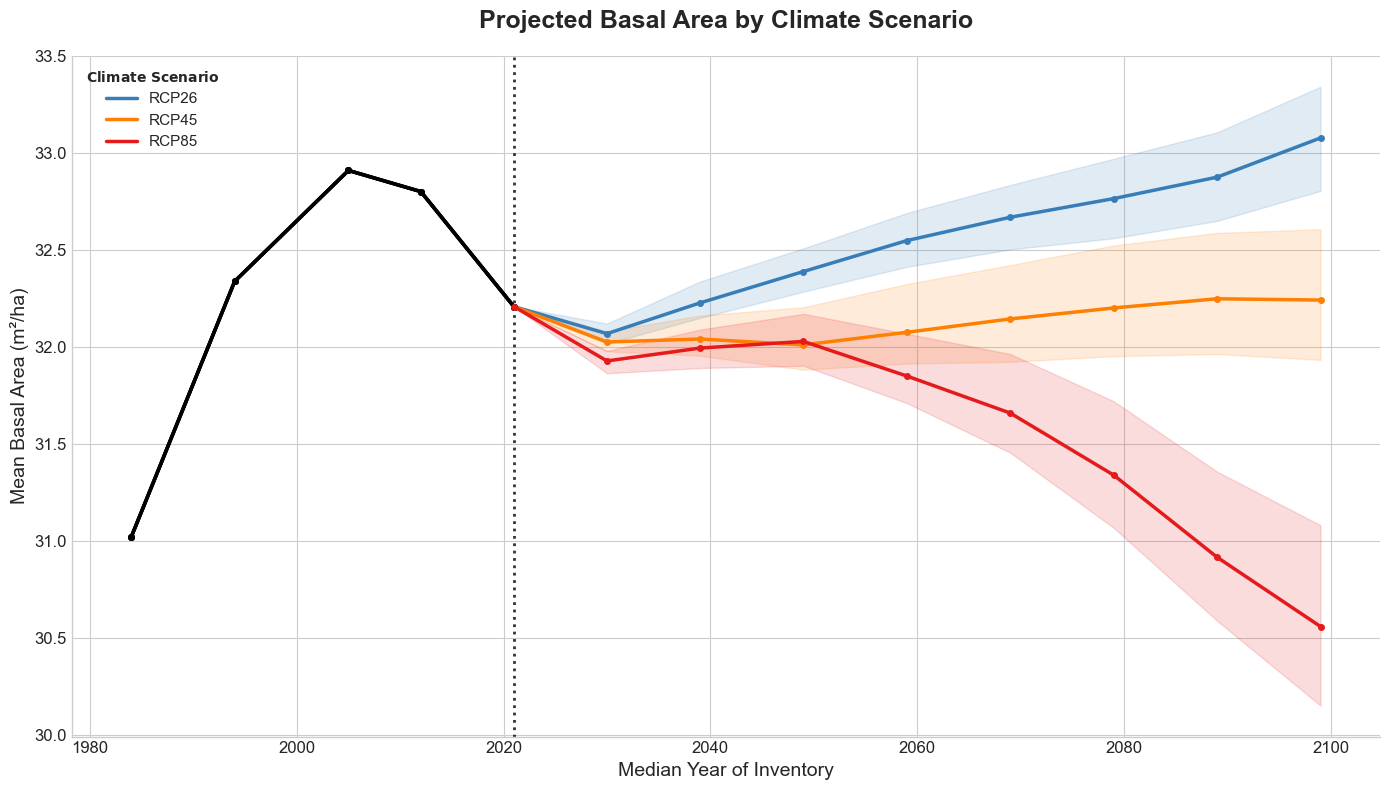

Saved PNG to: ../figures/predictions/hw_proportion_by_scenario.png
Saved PDF to: ../figures/predictions/hw_proportion_by_scenario.pdf


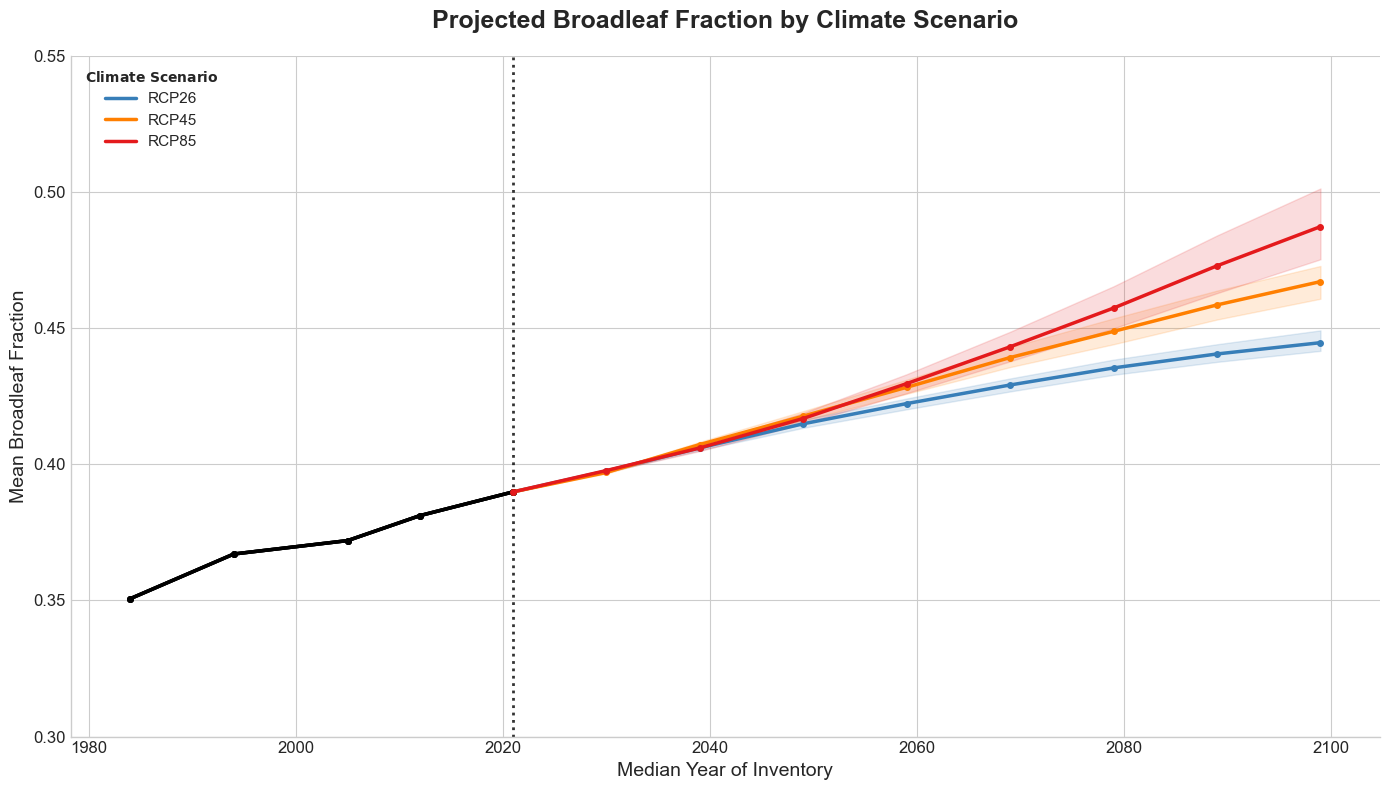

In [47]:
# --- Reusable Plotting Function (by Scenario Only) ---

def create_plot_by_scenario(
    data, x_col, y_mean_col, y_min_col, y_max_col, 
    y_label, title, output_filename, 
    color_palette, prediction_start_year, ylim=None
):
    """Generates a plot by climate scenario only (no management split)."""
    fig, ax = plt.subplots(figsize=(14, 8))

    for rcp in sorted(data['rcp'].unique()):
        subset_data = data[data['rcp'] == rcp].sort_values(x_col)
        color = color_palette.get(rcp)

        # Split historical/future
        hist_data = subset_data[subset_data[x_col] <= prediction_start_year]
        fut_data  = subset_data[subset_data[x_col] >= prediction_start_year]

        # Historical part (black)
        if not hist_data.empty:
            ax.plot(
                hist_data[x_col], hist_data[y_mean_col],
                color='black', linewidth=2.5, linestyle='solid',
                marker='o', markersize=4, zorder=10
            )


        # Future part (colored)
        if not fut_data.empty:
            ax.plot(
                fut_data[x_col], fut_data[y_mean_col],
                color=color, linewidth=2.5, linestyle='solid',
                marker='o', markersize=4, zorder=10
            )
            ax.fill_between(
                fut_data[x_col], fut_data[y_min_col], fut_data[y_max_col],
                color=color, alpha=0.15, zorder=5
            )

    # Legend: climate scenarios only
    legend_handles = [Line2D([0], [0], color=c, lw=2.5) for c in color_palette.values()]
    ax.legend(legend_handles, list(color_palette.keys()),
              loc='upper left', fontsize=LEGEND_FONTSIZE, handlelength=2,
              title=r"$\bf{Climate\ Scenario}$")

    # Prediction start line
    ax.axvline(x=prediction_start_year, color='black', linestyle=':', lw=2, alpha=0.8)

    # Titles & labels
    ax.set_title(title, fontsize=TITLE_FONTSIZE, pad=20, weight='bold')
    ax.set_xlabel("Median Year of Inventory", fontsize=AXIS_LABEL_FONTSIZE)
    ax.set_ylabel(y_label, fontsize=AXIS_LABEL_FONTSIZE)
    if ylim: ax.set_ylim(ylim)
    ax.tick_params(axis='both', which='major', labelsize=TICK_LABEL_FONTSIZE)
    sns.despine(ax=ax)
    plt.tight_layout()

    # Save
    png_path = output_filename.with_suffix('.png')
    plt.savefig(png_path, dpi=300, bbox_inches='tight')
    print(f"Saved PNG to: {png_path}")
    pdf_path = output_filename.with_suffix('.pdf')
    plt.savefig(pdf_path, bbox_inches='tight')
    print(f"Saved PDF to: {pdf_path}")
    plt.show()


# --- Build scenario-level data directly from master_df ---

# Per-seed means by rcp & INVNR (no management filter)
per_seed_means = (
    master_df
    .groupby(['rcp', 'INVNR', 'seed'], as_index=False)
    .agg(
        mean_BASFPH=('BASFPH', 'mean'),
        mean_HWSW_prop=('HWSW_prop', 'mean')
    )
)

# Across seeds: mean + 5/95% quantiles of the per-seed means
plot_data_no_mgmt = (
    per_seed_means
    .groupby(['rcp', 'INVNR'], as_index=False)
    .agg(
        final_mean_BASFPH=('mean_BASFPH', 'mean'),
        min_BASFPH=('mean_BASFPH', 'min'),
        max_BASFPH=('mean_BASFPH', 'max'),
        final_mean_HWSW_prop=('mean_HWSW_prop', 'mean'),
        min_HWSW_prop=('mean_HWSW_prop', 'min'),
        max_HWSW_prop=('mean_HWSW_prop', 'max'),
    )
    .merge(year_map, on='INVNR', how='left')  # uses your existing year_map from above
    .rename(columns={'median_year_per_INVNR': 'mean_year'})
    .sort_values(['rcp', 'mean_year'])
)

# Prediction start year 
prediction_start_year = int(year_map.loc[year_map['INVNR'] == PREDICTION_START_INVNR, 'median_year_per_INVNR'].iloc[0])

# --- Plots (scenario-only) ---

# Basal Area
create_plot_by_scenario(
    data=plot_data_no_mgmt, x_col='mean_year', y_mean_col='final_mean_BASFPH',
    y_min_col='min_BASFPH', y_max_col='max_BASFPH',
    y_label='Mean Basal Area (m²/ha)',
    title='Projected Basal Area by Climate Scenario',
    output_filename=output_dir / 'basal_area_by_scenario',
    color_palette=COLOR_PALETTE,
    prediction_start_year=prediction_start_year
)

# Broadleaf Fraction
create_plot_by_scenario(
    data=plot_data_no_mgmt, x_col='mean_year', y_mean_col='final_mean_HWSW_prop',
    y_min_col='min_HWSW_prop', y_max_col='max_HWSW_prop',
    y_label='Mean Broadleaf Fraction',
    title='Projected Broadleaf Fraction by Climate Scenario',
    output_filename=output_dir / 'hw_proportion_by_scenario',
    color_palette=COLOR_PALETTE,
    prediction_start_year=prediction_start_year,
    ylim=(0.3, 0.55)  # keep if you want a fixed y-range
)


Saved PNG to: ../figures/predictions/basal_area_change_by_veg_belt_all_plots.png
Saved PDF to: ../figures/predictions/basal_area_change_by_veg_belt_all_plots.pdf


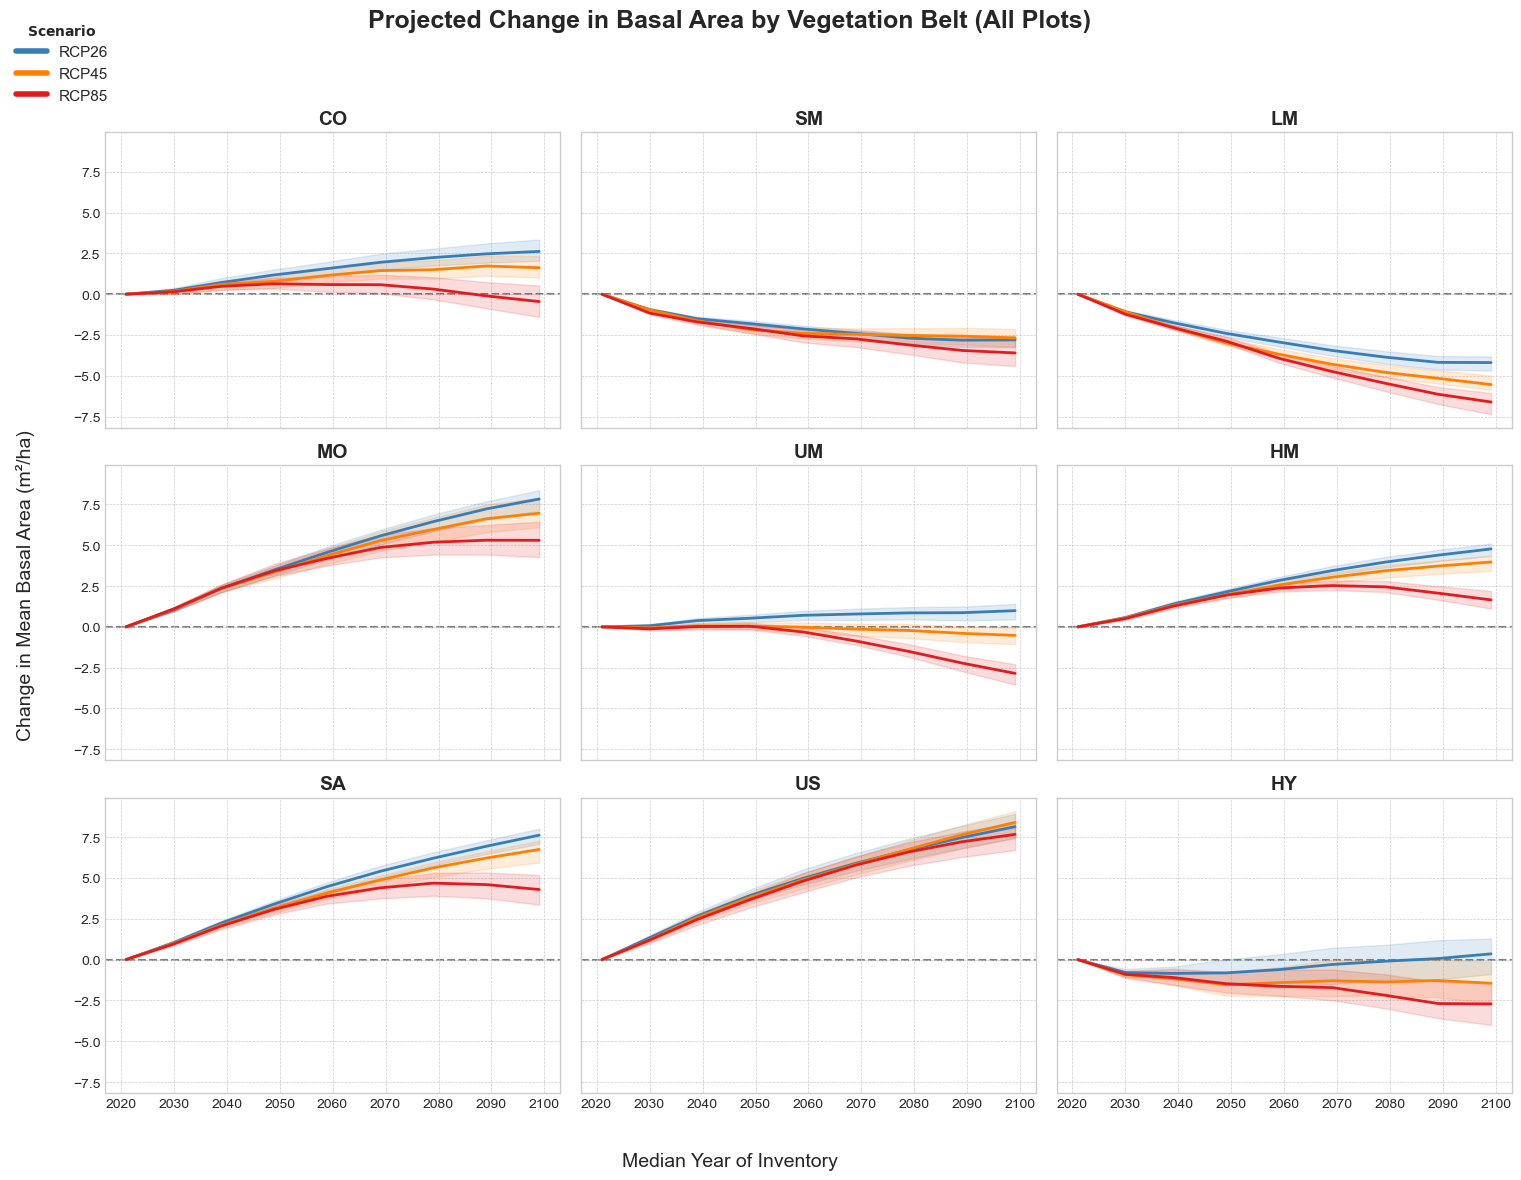

Saved PNG to: ../figures/predictions/basal_area_change_by_veg_belt_managed_only.png
Saved PDF to: ../figures/predictions/basal_area_change_by_veg_belt_managed_only.pdf


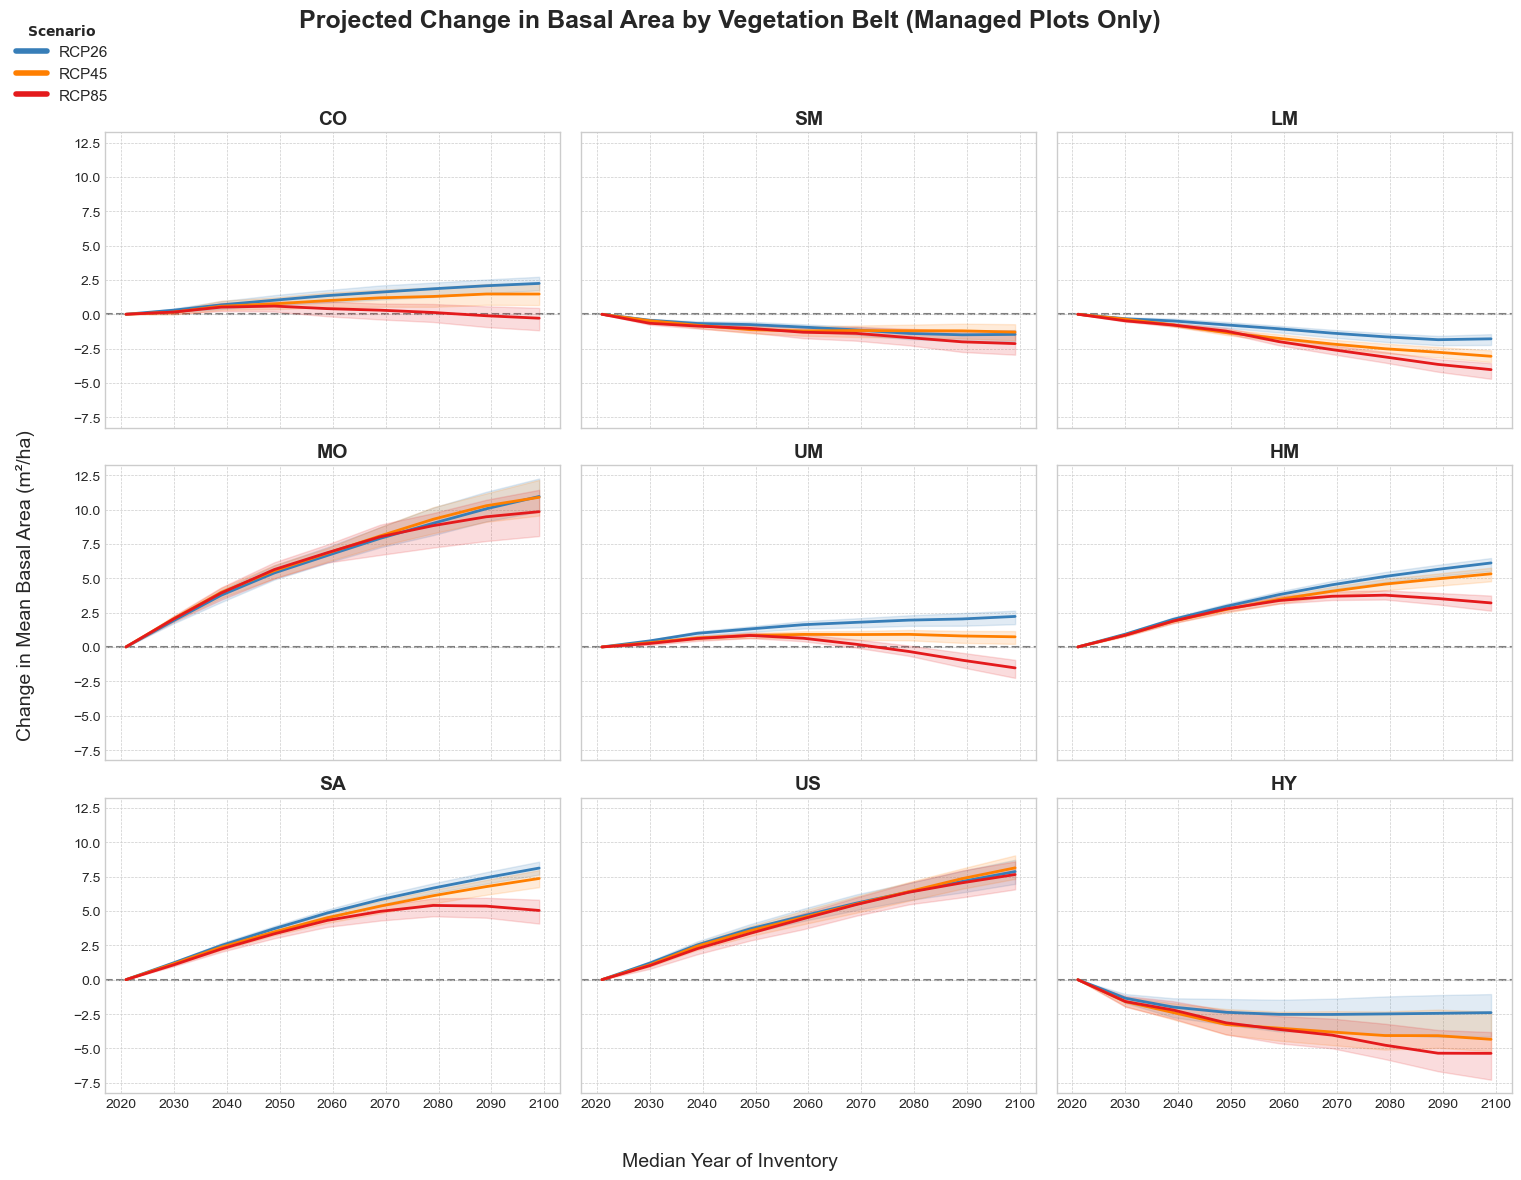

Saved PNG to: ../figures/predictions/basal_area_change_by_veg_belt_unmanaged_only.png
Saved PDF to: ../figures/predictions/basal_area_change_by_veg_belt_unmanaged_only.pdf


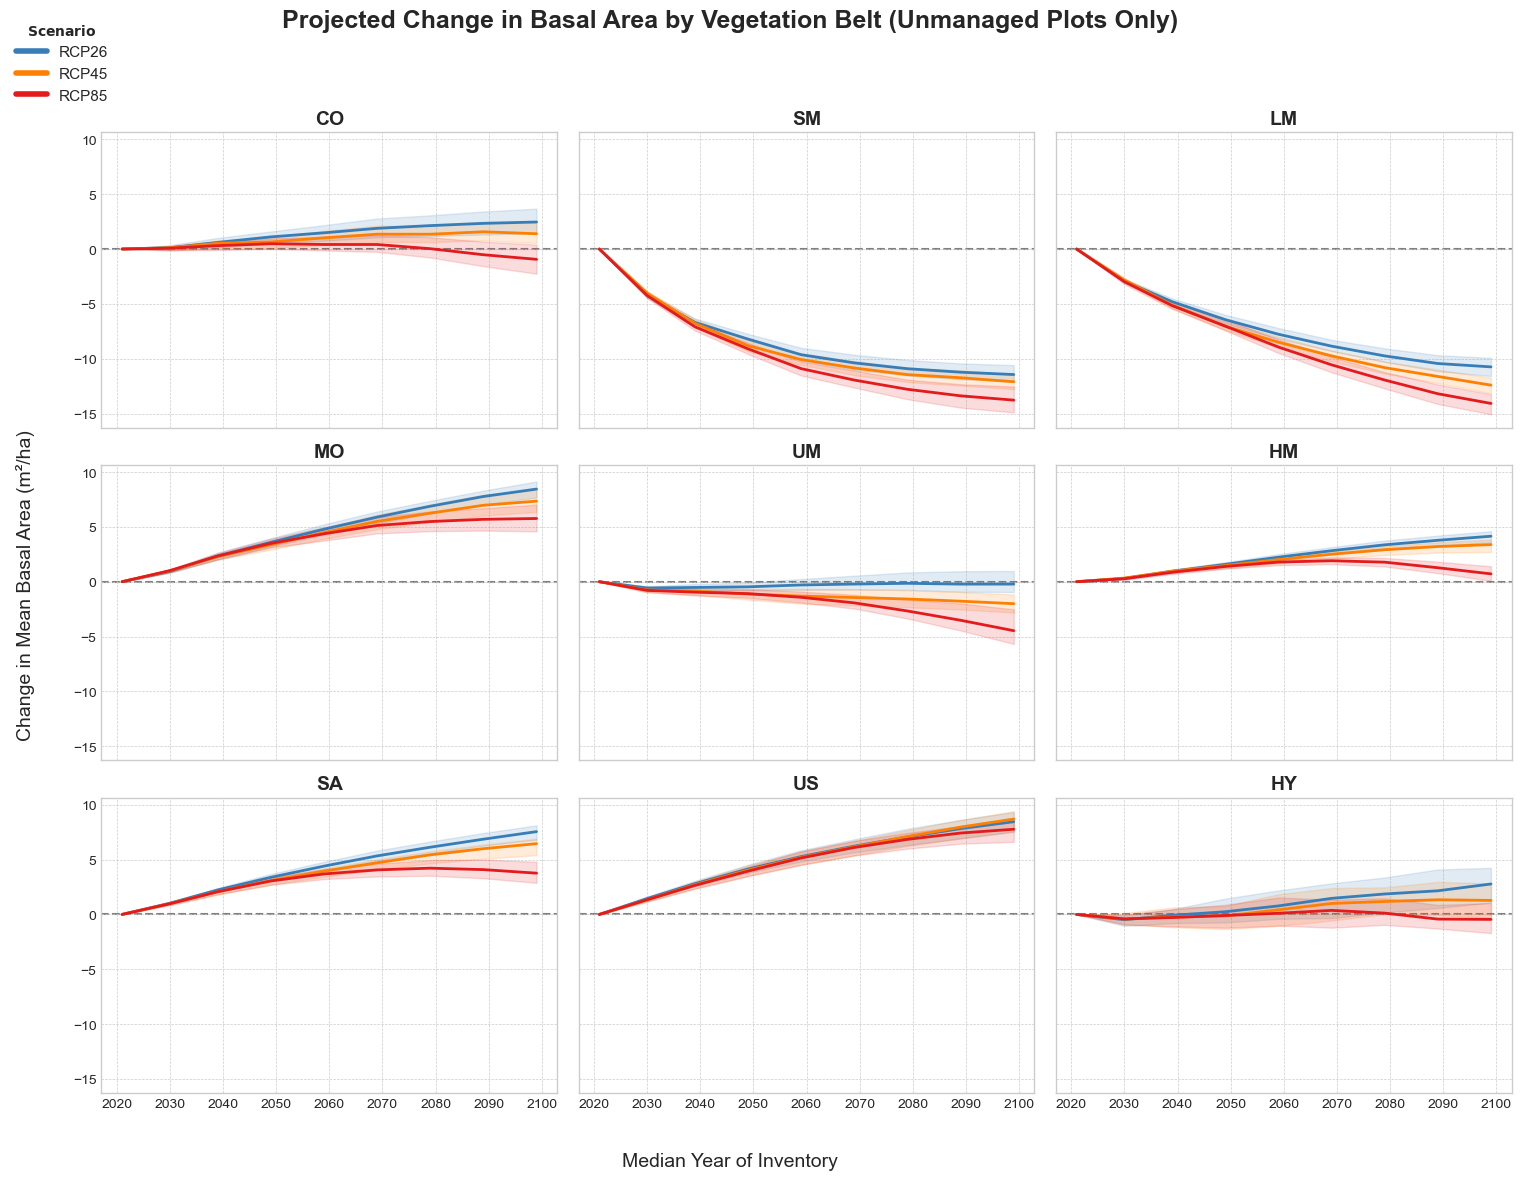

Saved PNG to: ../figures/predictions/hw_proportion_change_by_veg_belt_all_plots.png
Saved PDF to: ../figures/predictions/hw_proportion_change_by_veg_belt_all_plots.pdf


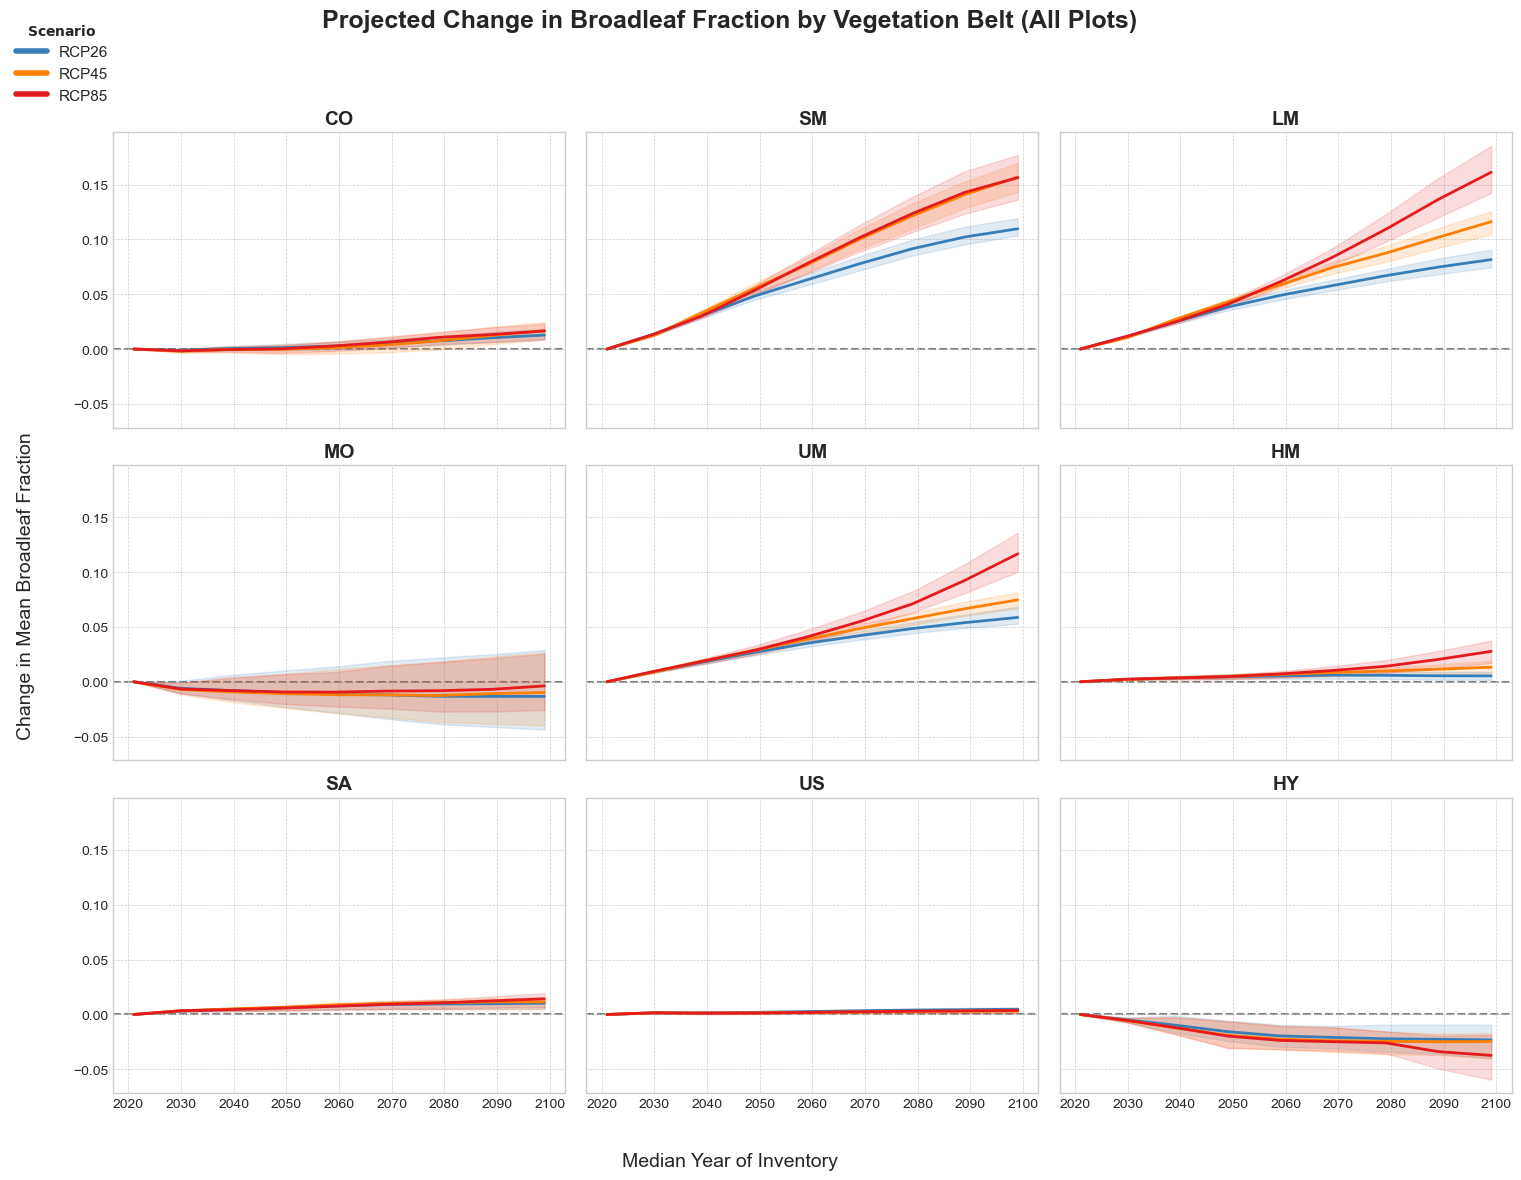

Saved PNG to: ../figures/predictions/hw_proportion_change_by_veg_belt_managed_only.png
Saved PDF to: ../figures/predictions/hw_proportion_change_by_veg_belt_managed_only.pdf


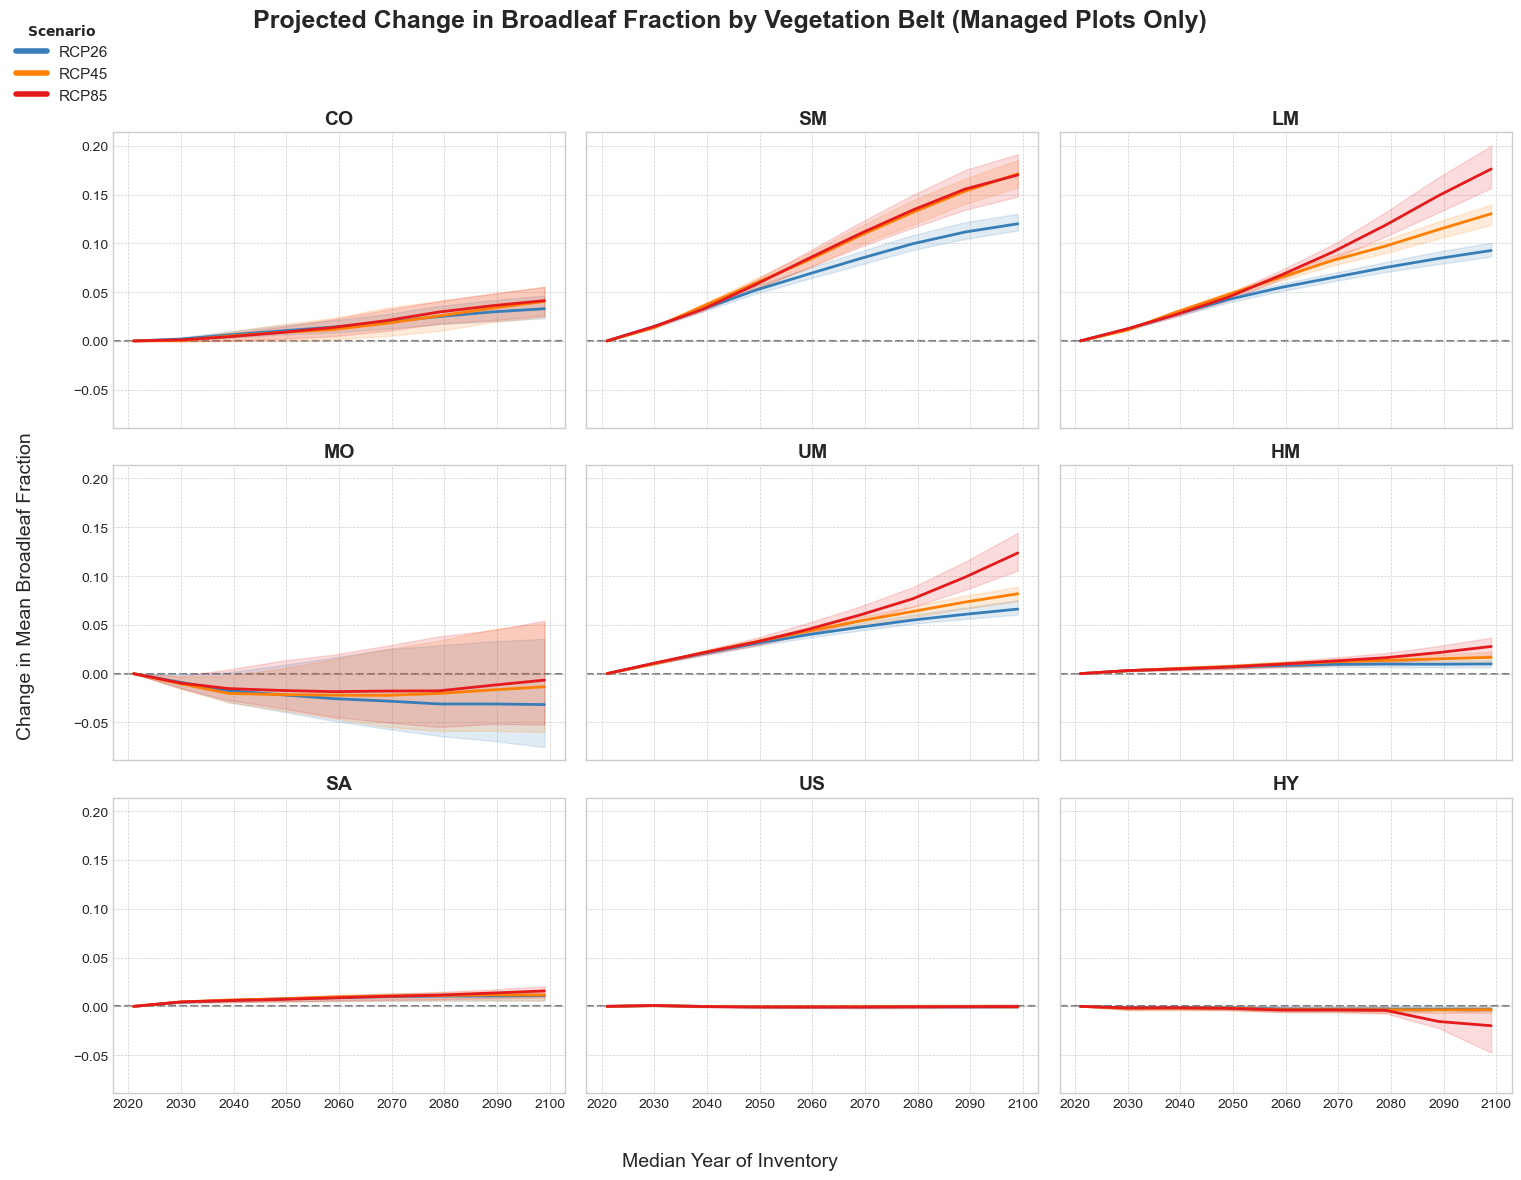

Saved PNG to: ../figures/predictions/hw_proportion_change_by_veg_belt_unmanaged_only.png
Saved PDF to: ../figures/predictions/hw_proportion_change_by_veg_belt_unmanaged_only.pdf


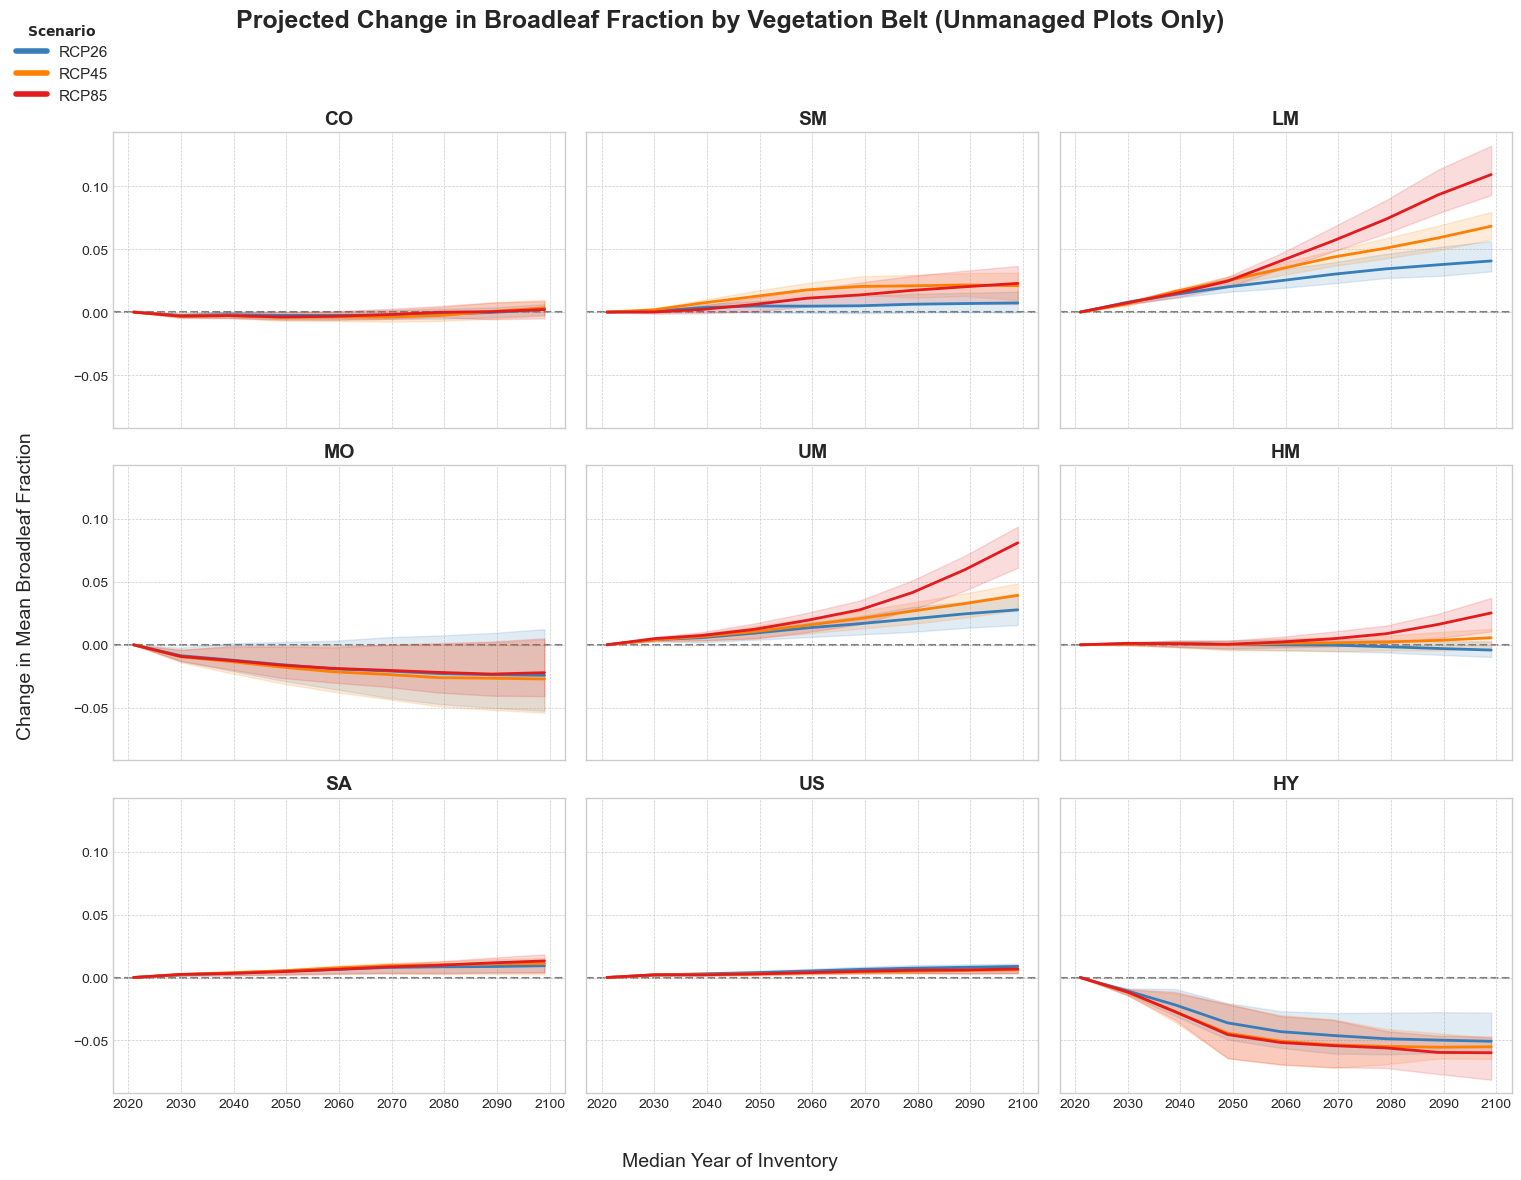

In [48]:
# --- Functions to prepare change-from-baseline data and create plots by vegetation belt ---

def _prepare_veg_belt_data_diff(
    df,
    year_map,
    management_type="All",
    value_col="BASFPH",
    prediction_start_invnr=PREDICTION_START_INVNR,
):
    """
    Prepares data by calculating the change from a baseline for a given metric,
    aggregated by vegetation belt.
    """

    # Management filter
    if management_type == "Managed":
        work_df = df[df["BEWIRTINT1"] == 1.0].copy()
    elif management_type == "Unmanaged":
        work_df = df[df["BEWIRTINT1"] == 3.0].copy()
    else:
        work_df = df.copy()

    # Keep only future inventories (including baseline INVNR)
    fut = work_df[work_df["INVNR"] >= prediction_start_invnr].copy()

    # Vegetation belt codes (short)
    veg_code_map = {k: v["short"] for k, v in VEG_BELT_MAP.items()}
    fut["Vegetation_Belt_Code"] = fut["NAISHSTKOMB"].map(veg_code_map)

    # Restrict to combos that have a baseline row at INVNR == prediction_start_invnr
    baseline_keys = (
        fut.loc[fut["INVNR"] == prediction_start_invnr, ["rcp", "CLNR", "seed"]]
        .drop_duplicates()
    )
    fut = fut.merge(baseline_keys, on=["rcp", "CLNR", "seed"], how="inner")

    # Build baseline values per (rcp, CLNR, seed)
    baseline = (
        fut.loc[fut["INVNR"] == prediction_start_invnr, ["rcp", "CLNR", "seed", value_col]]
        .rename(columns={value_col: f"{value_col}_start"})
    )

    # Merge baseline into all future rows and compute difference
    fut = fut.merge(baseline, on=["rcp", "CLNR", "seed"], how="left")
    fut[f"{value_col}_diff_from_start"] = fut[value_col] - fut[f"{value_col}_start"]

    # Per-seed mean difference per (rcp, INVNR, Vegetation_Belt_Code)
    per_seed = (
        fut.groupby(["rcp", "INVNR", "seed", "Vegetation_Belt_Code"], as_index=False)
           .agg(mean_diff_per_seed=(f"{value_col}_diff_from_start", "mean"))
    )

    # Across seeds: mean + q05/q95 
    agg = (
        per_seed.groupby(["rcp", "INVNR", "Vegetation_Belt_Code"], as_index=False)
                .agg(
                    final_mean_diff=("mean_diff_per_seed", "mean"),
                    min_diff=("mean_diff_per_seed", "min"),
                    max_diff=("mean_diff_per_seed", "max"),
                )
    )

    # Use the SAME median year per INVNR as above
    agg = agg.merge(year_map[["INVNR", "median_year_per_INVNR"]],
                    on="INVNR", how="left")
    agg = agg.rename(columns={"median_year_per_INVNR": "mean_year"})


    # Order
    agg = agg.sort_values(["rcp", "Vegetation_Belt_Code", "mean_year"]).reset_index(drop=True)
    return agg


def _plot_veg_belt_change_facets(
    plot_data,
    title,
    y_label,
    output_filename_base,
    ylim=None,
):
    """
    Generates a faceted plot showing change over time, with one subplot per vegetation belt.
    """

    # Layout
    n_panels = len(VEG_BELT_ORDER)
    n_cols = 3
    n_rows = 3

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 4), sharey=True, sharex=True)
    axes = axes.flatten() # flatten the axes array

    # Create a panel for each vegetation belt
    for i, veg_code in enumerate(VEG_BELT_ORDER):
        ax = axes[i]
        sub_belt = plot_data[plot_data["Vegetation_Belt_Code"] == veg_code]

        # Draw a line for each RCP scenario within the panel
        for rcp in rcp_scenarios:  # deterministic order
            sub = sub_belt[sub_belt["rcp"] == rcp].copy()

            sub = sub.sort_values("mean_year")
            c = COLOR_PALETTE.get(rcp)

            # Plot the mean change and the confidence interval
            ax.plot(
                sub["mean_year"], sub["final_mean_diff"],
                color=c, linewidth=2
            )
            ax.fill_between(
                sub["mean_year"], sub["min_diff"], sub["max_diff"],
                color=c, alpha=0.15
            )

        # Customize the panel
        ax.set_title(veg_code, fontsize=AXIS_LABEL_FONTSIZE, weight="bold")
        ax.axhline(0, ls="--", color="gray", zorder=0) # horizontal zero line
        if ylim is not None:
            ax.set_ylim(ylim)
        ax.grid(True, which="major", linestyle="--", linewidth=0.5)

    # Hide any extra axes
    #for j in range(n_panels, len(axes)):
    #    axes[j].set_visible(False)

    # Add overall figure labels, title, and a single shared legend
    fig.text(0.5, 0.02, "Median Year of Inventory", ha="center", va="center", fontsize=AXIS_LABEL_FONTSIZE)
    fig.text(0.06, 0.5, y_label, ha="center", va="center", rotation="vertical", fontsize=AXIS_LABEL_FONTSIZE)

    legend_handles = [Line2D([0], [0], color=COLOR_PALETTE[k], lw=4) for k in rcp_scenarios]
    fig.legend(
        handles=legend_handles, labels=rcp_scenarios,
        loc="upper right", bbox_to_anchor=(0.12, 0.98),
        fontsize=LEGEND_FONTSIZE, title=r"$\bf{Scenario}$"
    )

    fig.suptitle(title, fontsize=TITLE_FONTSIZE, weight="bold", y=0.98)
    plt.tight_layout(rect=[0.08, 0.05, 1, 0.94])

    # Save
    png_path = output_filename_base.with_suffix(".png")
    plt.savefig(png_path, dpi=300, bbox_inches="tight")
    print(f"Saved PNG to: {png_path}")
    pdf_path = output_filename_base.with_suffix(".pdf")
    plt.savefig(pdf_path, bbox_inches="tight")
    print(f"Saved PDF to: {pdf_path}")
    plt.show()



# --- BASFPH change (All / Managed / Unmanaged) ---
data_all_bas = _prepare_veg_belt_data_diff(master_df, year_map, "All", "BASFPH", PREDICTION_START_INVNR)
_plot_veg_belt_change_facets(
    data_all_bas,
    title="Projected Change in Basal Area by Vegetation Belt (All Plots)",
    y_label="Change in Mean Basal Area (m²/ha)",
    output_filename_base=output_dir / "basal_area_change_by_veg_belt_all_plots"
)

data_man_bas = _prepare_veg_belt_data_diff(master_df, year_map, "Managed", "BASFPH", PREDICTION_START_INVNR)
_plot_veg_belt_change_facets(
    data_man_bas,
    title="Projected Change in Basal Area by Vegetation Belt (Managed Plots Only)",
    y_label="Change in Mean Basal Area (m²/ha)",
    output_filename_base=output_dir / "basal_area_change_by_veg_belt_managed_only"
)

data_unman_bas = _prepare_veg_belt_data_diff(master_df, year_map, "Unmanaged", "BASFPH", PREDICTION_START_INVNR)
_plot_veg_belt_change_facets(
    data_unman_bas,
    title="Projected Change in Basal Area by Vegetation Belt (Unmanaged Plots Only)",
    y_label="Change in Mean Basal Area (m²/ha)",
    output_filename_base=output_dir / "basal_area_change_by_veg_belt_unmanaged_only"
)

# --- HWSW_prop change (All / Managed / Unmanaged) ---
data_all_prop = _prepare_veg_belt_data_diff(master_df, year_map, "All", "HWSW_prop", PREDICTION_START_INVNR)
_plot_veg_belt_change_facets(
    data_all_prop,
    title="Projected Change in Broadleaf Fraction by Vegetation Belt (All Plots)",
    y_label="Change in Mean Broadleaf Fraction",
    output_filename_base=output_dir / "hw_proportion_change_by_veg_belt_all_plots"
)

data_man_prop = _prepare_veg_belt_data_diff(master_df, year_map, "Managed", "HWSW_prop", PREDICTION_START_INVNR)
_plot_veg_belt_change_facets(
    data_man_prop,
    title="Projected Change in Broadleaf Fraction by Vegetation Belt (Managed Plots Only)",
    y_label="Change in Mean Broadleaf Fraction",
    output_filename_base=output_dir / "hw_proportion_change_by_veg_belt_managed_only"
)

data_unman_prop = _prepare_veg_belt_data_diff(master_df, year_map, "Unmanaged", "HWSW_prop", PREDICTION_START_INVNR)
_plot_veg_belt_change_facets(
    data_unman_prop,
    title="Projected Change in Broadleaf Fraction by Vegetation Belt (Unmanaged Plots Only)",
    y_label="Change in Mean Broadleaf Fraction",
    output_filename_base=output_dir / "hw_proportion_change_by_veg_belt_unmanaged_only"
)


In [49]:
# --- Diagnostic: Count of Unique Plots per Vegetation Belt ---

print("--- Diagnostic: Number of Unique Plots per Vegetation Belt (NAISHSTKOMB) ---")

master_df= master_df[master_df['INVNR'] == 550]  # Filter for the prediction start inventory number
#master_df = master_df[master_df['BEWIRTINT1']==1.0]  # Filter for managed (1.0) and unmanaged (3.0) plots

# Get a dataframe with only one row per unique plot (CLNR). Just for safety.
unique_plots_df = master_df[['CLNR', 'NAISHSTKOMB']].drop_duplicates(subset=['CLNR'])

# Count the occurrences of each NAISHSTKOMB code
plot_counts = unique_plots_df['NAISHSTKOMB'].value_counts().sort_index()

# Create summary table
summary_df = plot_counts.reset_index()
summary_df.columns = ['NAISHSTKOMB_Code', 'Number_of_Plots']

# Map the long names for readability
veg_long_name_map = {k: v['long'] for k, v in VEG_BELT_MAP.items()}
summary_df['Vegetation_Belt_Name'] = summary_df['NAISHSTKOMB_Code'].map(veg_long_name_map)

# Reorder columns for the final print
summary_df = summary_df[['NAISHSTKOMB_Code', 'Vegetation_Belt_Name', 'Number_of_Plots']]

print(summary_df.to_string(index=False))

# Print total and perform a sanity check
total_plots_from_counts = summary_df['Number_of_Plots'].sum()
total_plots_from_nunique = master_df['CLNR'].nunique()

print("\n" + "-"*50)
print(f"Total unique plots found in summary: {total_plots_from_counts}")
print(f"Total unique CLNRs in master_df:    {total_plots_from_nunique}")
if total_plots_from_counts == total_plots_from_nunique:
    print("SUCCESS: The total plot count is consistent.")
else:
    print("WARNING: Mismatch in total plot counts. Please review the data.")

--- Diagnostic: Number of Unique Plots per Vegetation Belt (NAISHSTKOMB) ---
 NAISHSTKOMB_Code    Vegetation_Belt_Name  Number_of_Plots
                1         Upper Subalpine              113
                2               Subalpine              392
                3            High-Montane              671
                4       Upper Montane (N)              774
                5       Lower Montane (N)              822
                6 Lower/Upper Montane (S)              134
                7          Submontane (N)              892
                8  Colline with Beech (S)              121
                9                 Colline               65
               10       Hyperinsubric (S)               10

--------------------------------------------------
Total unique plots found in summary: 3994
Total unique CLNRs in master_df:    3994
SUCCESS: The total plot count is consistent.
